### Libraries 

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

connection = sqlite3.connect('../data/database.db')

df_wowtoken = pd.read_sql_query("SELECT * FROM wowtoken WHERE date!=''", connection)
df_currency = pd.read_sql_query("SELECT * FROM currency WHERE date!=''", connection)

connection.close()

Removing unuseful columns

In [2]:
df_wowtoken = df_wowtoken.drop(["id", "index"], axis=1)
df_currency = df_currency.drop(["id",'index'], axis=1)

### Raw currency dataframe

In [3]:
df_currency.head()

,date,time,Usd,Eur,Cny,Krw,Brl
0,03/27/2019,14:40:02,1,0.885661146,6.7149056771,1134.4522185812,None
1,03/27/2019,15:00:01,1,0.885661146,6.7149056771,1134.4522185812,None
2,03/27/2019,15:20:02,1,0.8880206021,6.7248912175,1137.5543912619,None
3,03/27/2019,15:40:02,1,0.8880206021,6.7248912175,1137.5543912619,None
4,03/27/2019,16:00:02,1,0.8880206021,6.7248912175,1137.5543912619,None


### Raw wowtoken dataframe

In [4]:
df_wowtoken.head()

,date,time,Us,Eu,Ch,Kr,Tw
0,03/02/2019,14:00:01,"111,249","159,930","184,765","242,896","263,267"
1,03/02/2019,14:20:01,"111,076","160,582","185,593","245,325","263,694"
2,03/02/2019,14:40:01,"111,096","160,815","186,028","247,778","263,088"
3,03/02/2019,15:00:01,"111,199","160,434","186,136","249,695","262,637"
4,03/02/2019,15:20:01,"111,234","160,014","186,335","250,066","262,494"


## Cleaning wowtoken dataframe

Replacing , with .

In [5]:
df_wowtoken["Us"] = df_wowtoken["Us"].str.replace(",", ".")
df_wowtoken["Eu"] = df_wowtoken["Eu"].str.replace(",", ".")
df_wowtoken["Ch"] = df_wowtoken["Ch"].str.replace(",", ".")
df_wowtoken["Kr"] = df_wowtoken["Kr"].str.replace(",", ".")
df_wowtoken["Tw"] = df_wowtoken["Tw"].str.replace(",", ".")

Converting from str to np.float64

In [6]:
df_wowtoken['Us'] = pd.to_numeric(df_wowtoken["Us"])
df_wowtoken['Eu'] = pd.to_numeric(df_wowtoken["Eu"])
df_wowtoken['Ch'] = pd.to_numeric(df_wowtoken["Ch"])
df_wowtoken['Kr'] = pd.to_numeric(df_wowtoken["Kr"])
df_wowtoken['Tw'] = pd.to_numeric(df_wowtoken["Tw"])

Converting date and time column to one column

In [7]:
s1 = (df_wowtoken['date']+' - '+df_wowtoken['time'])

#altering format
s1 = pd.to_datetime(s1, infer_datetime_format=True) 

#removing columns
df_wowtoken = df_wowtoken.drop(['date', 'time'], axis=1)

# add new column
df_wowtoken['date'] = s1

#reordering colmuns
df_wowtoken = df_wowtoken[['date','Us', 'Eu', 'Ch', 'Kr', 'Tw']]

## Cleaning currency dataframe

Filling NULL values in Brl Column

In [8]:
# Copying the last value
s1 = df_currency['Brl']
# there is no data frmo 0 to 234
# so I copy the last values
s1[0:235] = s1[235]
df_currency['Brl'] = s1

Converting from str to np.float64

In [9]:
df_currency['Usd'] = pd.to_numeric(df_currency['Usd'])
df_currency['Eur'] = pd.to_numeric(df_currency['Eur'])
df_currency['Cny'] = pd.to_numeric(df_currency['Cny'])
df_currency['Krw'] = pd.to_numeric(df_currency['Krw'])
df_currency['Brl'] = pd.to_numeric(df_currency['Brl'])

Converting date and time column to one column

In [10]:
s1 = (df_currency['date']+' - '+df_currency['time'])

#altering format
s1 = pd.to_datetime(s1, infer_datetime_format=True) 

#removing columns
df_currency = df_currency.drop(['date', 'time'], axis=1)

# add new column
df_currency['date'] = s1

#reordering colmuns
df_currency = df_currency[['date','Usd', 'Eur', 'Cny', 'Krw', 'Brl']]

### Putting wowtoken at the same level of rows of currency

In [11]:
diff = df_currency['date'][0] - df_wowtoken['date'][0]
            # 72 rows / day + 3 rows/ hour
registers = diff.days*72 + (int)(diff.seconds/60/20)
df_wowtoken = df_wowtoken[registers-1:]

# Reset index and drop new column
df_wowtoken.reset_index(inplace=True)
df_wowtoken.drop('index', axis=1, inplace=True)

Filling NA values with interpolation

In [12]:
print('NA values before interpolation:',len(df_wowtoken[df_wowtoken.isna().any(axis=1)]))
df_wowtoken = df_wowtoken.interpolate()
print('NA values after  interpolation:',len(df_wowtoken[df_wowtoken.isna().any(axis=1)]))

NA values before interpolation: 301
NA values after  interpolation: 0


### Sorting by day

Wowtoken dataframe

In [13]:
# Wowtoken
df_d_wowtoken = df_wowtoken
df_d_wowtoken = df_d_wowtoken.set_index('date').groupby(pd.Grouper(freq='d')).mean()

Currency dataframe

In [14]:
df_d_currency = df_currency
df_d_currency = df_d_currency.set_index('date').groupby(pd.Grouper(freq='d')).mean()

### Interpoling missing days

Wowtoken dataframe

In [15]:
print('missing days before interpolation:',len(df_d_currency[df_d_currency.isna().any(axis=1)])) # - > missing 5 values
df_d_currency = df_d_currency.interpolate()
df_d_currency[df_d_currency.isna().any(axis=1)]
print('missing days after  interpolation:', len(df_d_currency[df_d_currency.isna().any(axis=1)]))

missing days before interpolation: 5
missing days after  interpolation: 0


Currency dataframe

In [16]:
print('missing days before interpolation:',len(df_d_wowtoken[df_d_wowtoken.isna().any(axis=1)])) # - > missing 1 value
df_d_wowtoken = df_d_wowtoken.interpolate()
print('missing days after  interpolation:',len(df_d_wowtoken[df_d_wowtoken.isna().any(axis=1)]))

missing days before interpolation: 1
missing days after  interpolation: 0


## Wowtoken plotting and analysing

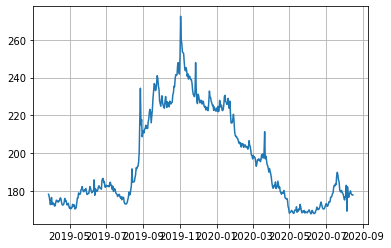

,Us,Eu,Ch,Kr,Tw
date,,,,,
2019-03-27,117.716913,178.372000,183.634870,222.632652,262.916609
2019-03-28,119.781986,177.239833,184.494875,247.775375,261.045806
2019-03-29,119.032681,175.309681,184.582653,244.074500,261.931611
2019-03-30,117.304958,172.900931,184.159403,237.340778,259.566597
2019-03-31,118.476528,174.331931,183.859097,232.301375,259.887569
...,...,...,...,...,...
2020-08-11,121.016458,180.129792,347.588667,209.921792,207.475125
2020-08-12,120.911542,178.567750,337.963917,210.931000,210.661236
2020-08-13,120.324611,178.170069,340.258875,208.436500,210.126944


In [17]:
plt.plot(df_d_wowtoken['Eu'])
plt.grid(True)
plt.show()
df_d_wowtoken

## Currency plotting and analysing

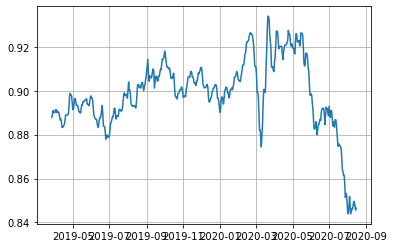

,Usd,Eur,Cny,Krw,Brl
date,,,,,
2019-03-27,1.0,0.887852,6.724178,1137.332807,3.904317
2019-03-28,1.0,0.889108,6.729310,1138.067383,3.904317
2019-03-29,1.0,0.890975,6.729450,1138.155510,3.904317
2019-03-30,1.0,0.890076,6.710903,1136.145972,3.904317
2019-03-31,1.0,0.890076,6.710903,1136.145972,3.904317
...,...,...,...,...,...
2020-08-11,1.0,0.849622,6.962855,1185.576784,5.422771
2020-08-12,1.0,0.849005,6.946544,1183.375744,5.430292
2020-08-13,1.0,0.847876,6.945662,1184.502044,5.407417


In [18]:
plt.plot(df_d_currency['Eur'])
plt.grid(True)
plt.show()
df_d_currency

### Setup interval

In [19]:
start = '2019-07-01'
end   = '2020-06-30' 

df_f_currency = pd.DataFrame([
    df_d_currency['Brl'][start:end],
    df_d_currency['Eur'][start:end],
    df_d_currency['Cny'][start:end],
    df_d_currency['Krw'][start:end],
    
]).T

df_f_wowtoken = pd.DataFrame([
    df_d_wowtoken['Us'][start:end],
    df_d_wowtoken['Eu'][start:end],
    df_d_wowtoken['Ch'][start:end],
    df_d_wowtoken['Kr'][start:end],
]).T

## New series (wowtoken / currency)

In [27]:
s1 = df_f_currency['Brl'] * 20 / df_f_wowtoken['Us'] 
s2 = df_f_currency['Eur'] * 20 / df_f_wowtoken['Eu']
s3 = df_f_currency['Cny'] * 20 / df_f_wowtoken['Ch']
s4 = df_f_currency['Krw'] * 20 / df_f_wowtoken['Kr']

df_f_gold = pd.DataFrame([s1, s2, s3, s4]).T

df_f_gold.rename(columns={0:'America', 1:'Europe', 2:'China', 3:'Korea'}, inplace=True)

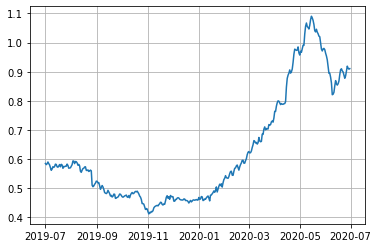

,America,Europe,China,Korea
date,,,,
2019-07-01,0.585229,0.096057,0.614860,84.890825
2019-07-02,0.581120,0.096487,0.607401,83.669206
2019-07-03,0.583999,0.096999,0.610542,84.453058
2019-07-04,0.590166,0.096963,0.614632,83.145563
2019-07-05,0.584652,0.097126,0.618509,82.478919
...,...,...,...,...
2020-06-26,0.902758,0.104583,0.357101,121.736471
2020-06-27,0.918988,0.104547,0.356838,121.446946
2020-06-28,0.912135,0.104560,0.355401,124.598303


In [31]:
plt.plot(df_f_gold['America'])
plt.grid(True)
plt.show()
df_f_gold

### Saving as a csv file

In [33]:
# Raw the data
#df_wowtoken.to_csv('../data/raw_wowtoken.csv')
#df_currency.to_csv('../data/raw_currency.csv')

# Sorted by day
df_f_gold.to_csv('../data/d_kilo_gold_price_in_currency.csv')
df_f_wowtoken.to_csv('../data/d_wowtoken_price_in_gold.csv')
df_f_currency.to_csv('../data/d_currency_price_in_dolar.csv')